# RomanDESC SN Simulation modeling with AstroPhot

Author: Michael Wood-Vasey <wmwv@pitt.edu>  
Last Verified to run: 2024-03-07

Use the [AstroPhot](https://autostronomy.github.io/AstroPhot/) package to model lightcurve of SN in Roman+Rubin DESC simulations

Notable Requirements:  
astrophot  
astropy  
torch  

Major TODO:
  * [ ] Decide on repo in Roman GitHub org.
  * [ ] Add MJD for SN.
  * [ ] Get simulation truth table
  * [ ] Mock up source list
  * [ ] Figure out photometric calibration zeropoint for: (a) truth table; (b) images
  * [ ] Test running 4 SNe
  * [ ] Start utility support Python file as developing package
  * [ ] Write tests for package.  Decide on test data.
  * [ ] Write logic into functions that can be more readily called from Python script
  * [~] Implement SIP WCS in AstroPhot to deal with slight variation in object positions
    - Instead implemented a per-image (but not per object) astrometric shift.

## Environment

This Notebook was developed and tested within a conda environment.  You can create this environment with:

```
conda create --name astrophot -c conda-forge python astropy cudatoolkit h5py  ipykernel jupyter matplotlib numpy pandas pyyaml pyarrow scipy requests tqdm 
conda activate astrophot
pip install astrophot pyro-ppl torch
ipython kernel install --user --name=astrophot
```

This requires astrophot >= v0.15.2

## Data

Use the data from the Roman+Rubin DESC simulations.

In [1]:
DATASET = "RomanDESC"
DATADIR = "data/RomanDESC"

In [2]:
import os
import re
from typing import Optional

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import iqr

import pandas as pd
import torch

import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.table import Table
from astropy.time import Time
from astropy.wcs import WCS

import astrophot as ap
from astrophot.image import PSF_Image, Window

### SN and Host position

In [3]:
data_dir = "data/RomanDESC"

image_file_format = (
    "images/{band}/{visit}/Roman_TDS_simple_model_{band}_{visit}_{sca}.fits.gz"
)
truth_file_for_image_format = (
    "truth/{band}/{visit}/Roman_TDS_index_{band}_{visit}_{sca}.txt"
)

Build our transient basic info catalog.

Note:
  * `mjd_start` is the earliest possible date we expect SN flux.  This would be computed based on some estimate of MJD_peak, redshift.
  * Identifying pre-explosion flux could be done by assuming an earlier start date.  This would require sufficient images prior to this to provide a static reference.  The same issues arise in subtractions from templates -- the building of the template assumes that there is no flux in the images of the template.

In [4]:
# 4 transient IDs of interest
transient_info_table = Table(
    rows=[
        (
            30328322,
            8.52941151,
            -43.0266337,
            62300,
            62600,
            "Off-center transient, clear host, noticeable background",
        ),
        (
            30005877,
            8.54125970,
            -43.0335549,
            62300,
            62600,
            "Faint blip",
        ),
        (
            30300185,
            8.53301717,
            -43.0415779,
            62300,
            62600,
            "Off-center transient; clear host galaxy.",
        ),
        (
            50006502,
            8.52961340,
            -43.0387536,
            62000,
            63000,
            "On-center transient; clear host galaxy.",
        ),
        (
            20202893,
            8.037774,
            -42.752337,
            62236.0,
            62707.0,
            "Example SNIa Lauren pointed to.",
        ),
    ],
    names=("object_id", "ra", "dec", "mjd_start", "mjd_end", "comment"),
    dtype=(np.int64, np.float64, np.float64, np.float64, np.float64, str),
)
transient_info_table.add_index("object_id")

transient_id_host = {
    30328322: {"ra": [8.529866, 8.530374], "dec": [-43.026571, -43.027145]},
    30005877: {
        "ra": [8.541223, 8.540226, 8.540089, 8.539467, 8.539475],
        "dec": [-43.033540, -43.033224, -43.033119, -43.033947, -43.033951],
    },
    30300185: {
        "ra": [8.533481], # , 8.532958, 8.535563],
        "dec": [-43.041704], # , -43.041007, -43.040616],
    },
    50006502: {
        "ra": [8.529611, 8.528555, 8.529122, 8.527552, 8.526931],
        "dec": [-43.038753, -43.038634, -43.039769, -43.039076, -43.038742],
    },
    20202893: {
        "ra": [8.037702, 8.037730, 8.039738],
        "dec": [-42.752296, -42.752924, -42.752543],
    },
}

In [5]:
def get_visit_band_sca_for_object_id(object_id):
    """
    Returns all of the image files that contain the location of the object.

    Note:
    For now this returns the results from a dict that was manually computed
    """
    visit_band_sca = {
        30328322: {
            "visit": [36445, 1394, 14088, 8340, 42193, 29499],
            "band": ["H158", "H158", "H158", "H158", "H158", "H158"],
            "sca": [17, 9, 8, 17, 8, 9],
        },
        30005877: {
            "visit": [1394, 8340, 14088, 29499, 36445, 42193],
            "band": ["H158", "H158", "H158", "H158", "H158", "H158"],
            "sca": [9, 17, 8, 9, 17, 8],
        },
        30300185: {
            "visit": [1394, 8340, 14088, 29499, 36445, 42193],
            "band": ["H158", "H158", "H158", "H158", "H158", "H158"],
            "sca": [9, 17, 8, 9, 17, 8],
        },
        50006502: {
            "visit": [1394, 8340, 14088, 29499, 36445, 42193],
            "band": ["H158", "H158", "H158", "H158", "H158", "H158"],
            "sca": [9, 17, 8, 9, 17, 8],
        },
        # Falls in chip gap for 14088, 42193
        20202893: {
            "visit": [
                1394,
                8340,
                11776,
                19907,
                25636,
                29499,
                36445,
                39881,
                48012,
                53741,
            ],
            "band": [
                "H158",
                "H158",
                "H158",
                "H158",
                "H158",
                "H158",
                "H158",
                "H158",
                "H158",
                "H158",
            ],
            "sca": [12, 1, 5, 10, 2, 12, 1, 5, 10, 2],
        },
    }

    # Could instead Raise exception once we have an exception framework
    if object_id not in visit_band_sca.keys():
        print(f"Object ID: '{object_id}' unknown.")
        return None

    return visit_band_sca[object_id]

In [6]:
# transient_id = 30328322
# transient_id = 20202893
# transient_id = 30005877
# transient_id = 30300185
transient_id = 50006502

In [7]:
transient_info = transient_info_table.loc[transient_id]
transient_host = transient_id_host[transient_id]
transient_coord = SkyCoord(transient_info["ra"], transient_info["dec"], unit=u.degree)

image_info = get_visit_band_sca_for_object_id(transient_id)

image_file_basenames = []
truth_file_basenames = []
for v, b, s in zip(image_info["visit"], image_info["band"], image_info["sca"]):
    image_file_basenames.append(image_file_format.format(visit=v, band=b, sca=s))
    truth_file_basenames.append(truth_file_for_image_format.format(visit=v, band=b, sca=s)    )

### Data files

In [8]:
image_files = [os.path.join(DATADIR, bn) for bn in image_file_basenames]
truth_files = [os.path.join(DATADIR, bn) for bn in truth_file_basenames]

In [9]:
def get_truth_table(truth_files, visits, transient_id):
    live_visits = []
    realized_flux = []
    flux = []
    mag = []

    for tf, v in zip(truth_files, visits):
        this_truth_table = Table.read(tf, format="ascii")
        idx = this_truth_table["object_id"] == transient_id
        if sum(idx) == 0:
            continue
        transient_entry = this_truth_table[idx]
        live_visits.append(v)
        realized_flux.append(transient_entry["realized_flux"][0])
        flux.append(transient_entry["flux"][0])
        mag.append(transient_entry["mag"][0])

    truth_table = Table(
        {
            "visit": live_visits,
            "realized_flux": realized_flux,
            "flux": flux,
            "mag": mag,
        }
    )

    return truth_table

In [10]:
lightcurve_truth = get_truth_table(truth_files, image_info["visit"], transient_id)

In [11]:
print(lightcurve_truth)

visit realized_flux    flux       mag    
----- ------------- ---------- ----------
 1394          74.0 70.2907753  10.456919
 8340        1712.0 1703.64232 6.99571878
14088        1174.0 1188.39546 7.38676237
29499         368.0 337.472264 8.75356962
36445         222.0 199.624893 9.32362809


## Roman PSF

The Roman Wide-Field Imager (WFI) PSF is available in detail through the `webbpsf` package.  But to simplify requirements for this tutorial (which are already pretty significant in the data), we will used a simplified pre-stored model of the PSF.  This model was generated with the following code:

```
import webbpsf

wfi = webbpsf.roman.WFI()
wfi.filter = "F106"
default_psf = wfi.calc_psf(outfile="roman_psf_nominal.fits")
```

For more information about Roman PSFs for the Wide-Field Imager, see

https://roman-docs.stsci.edu/simulation-tools-handbook-home/webbpsf-for-roman/webbpsf-tutorials
https://github.com/spacetelescope/webbpsf/blob/develop/notebooks/WebbPSF-Roman_Tutorial.ipynb

For actual usage, you should calculate the PSF for the specific observation, including detector (SCA).  Most notably, there is spatial variation of the PSF, and different roll angles will put the diffraction spikes in different places.  But we're just using simple approximations for now.

In [12]:
if DATASET == "RomanDESC":
    with fits.open("roman_psf_nominal.fits") as hdu:
        pixstep = hdu["OVERSAMP"].header["PIXELSCL"]
        psf = hdu["OVERSAMP"]

### Detector, Image, and FITS file order

In [13]:
# These are 4k x 4k images
pixel_scale = {"DC2": 0.2, "RomanDESC": 0.11}  # "/pixel
fwhm = {"DC2": 0.6, "RomanDESC": 0.2}  # "

# The HDU order is different between the two datasets
HDU_IDX = {
    "DC2": {"image": 1, "mask": 2, "variance": 3, "psfex_info": 11, "psfex_data": 12},
    "RomanDESC": {"image": 1, "mask": 3, "variance": 2},
}
# as are the FITS extension names
HDU_NAMES = {
    "DC2": {"image": "image", "mask": "mask", "variance": "variance"},
    "RomanDESC": {"image": "SCI", "mask": "DQ", "variance": "ERR"},
}
# so we have to use a translation regardless.

# But the variance plane for the Roman images isn't actually right
# So we use the Image plane for the variance.
HDU_IDX["RomanDESC"]["variance"] = HDU_IDX["RomanDESC"]["image"]
HDU_NAMES["RomanDESC"]["variance"] = HDU_NAMES["RomanDESC"]["image"]

In [14]:
### Bad pixel mask values
bad_pixel_bitmask = {}

## Roman
bad_pixel_bitmask["RomanDESC"] = 0b1

### Image metadata table

If you have the information, create a image metadata table here called `image_metadata`.  It will be used below to add key information to the AstroPhot target header metadata and which will in turn be used to build the lightcurve table for the photometry.  The table should have rows in the same order as the `image_file_basenames` (and `image_files`) arrays.  It is expected to have "mjd" and "band".

#### RomanSN
For Roman SN simulation, 
For the SN truth values, 

In [15]:
zp_AB_to_nJy = 8.90 + 2.5 * 9

### General SN+host fitting

The rest of this Notebook should work in general for any data set (`image_files`), SN coordinates (`sn`), host coordinates (`host`), and lightcurve seeded with a column for MJD (`lightcurve`) set up above.

In [16]:
DEFAULT_ZP = 22.5  # Appropriate if the image was calibrated and scaled to nanomaggies
DEFAULT_ZP = zp_AB_to_nJy

def make_target(
    image_filepath,
    coord: Optional[SkyCoord] = None,
    fwhm: float = fwhm[DATASET],
    psf_size: int = 51,
    pixel_scale: float = pixel_scale[DATASET],
    zeropoint: Optional[float] = None,
    hdu_idx: dict = HDU_IDX[DATASET],
    bad_pixel_bitmask: Optional[int] = bad_pixel_bitmask[DATASET],
    do_mask=False,
):
    """Make an AstroPhot target.

    image_filepath: str, Filepath to image file.
        Image file assumed to have [image, mask, variance].
        WCS assumed to be present in image HDU header

    coord: SkyCoord object with center of window
    fwhm: float, Full-Width at Half-Maximum in arcsec
    psf_size: float, width of the PSF
    pixel_scale: float, "/pix
       This is used along with fwhm, psf_size to set a Gaussian PSF model
       Would be better to have an actual PSF model from the image
    pixel_shape: (int, int), pix
    zeropoint: float, calibration of counts in image.
    """
    hdu = fits.open(image_filepath)
    header = hdu[0].header  # Primary header
    img = hdu[hdu_idx["image"]].data  # Image HDU
    var = hdu[hdu_idx["variance"]].data  # Variance HDU

    mjd = header["MJD-OBS"]
    band = header["FILTER"]
    
    zp_band = {"H158": 32.603}
    sigma_to_fwhm = 2.355

    if do_mask:
        # But need to translate the informative mask with a bad-pixel mask.
        # E.g., for an LSST Science Pipelines mask, one of the mask values
        # is that that pixel is part of a footprint of a valid object
        # We don't want to mask those!
        informative_mask = hdu[hdu_idx["mask"]].data  # Mask
        bad_pixel_mask = informative_mask & bad_pixel_bitmask

    # LSST Science Pipelines processed data will store a zeropoint in MAGZERO
    if zeropoint is None:
        try:
            zeropoint = zp_band[band] # + 2.5 * np.log10(header["EXPTIME"])
        except:
            zeropoint = DEFAULT_ZP

    wcs = WCS(hdu[hdu_idx["image"]].header)

    # If a PSF image is available, use it to calculate FWHM
    if "psfex_info" in hdu_idx.keys():
        pixstep, psf = read_psfex_image(
            hdu[hdu_idx["psfex_info"]], hdu[hdu_idx["psfex_data"]], resample=True,
        )
        pixel_scale = 3600 * wcs.pixel_scale_matrix

        fwhm = calc_fwhm_from_psf_image(psf)
    else:
        # we construct a basic gaussian psf for each image
        # by giving the simga (arcsec), image width (pixels), and pixelscale (arcsec/pixel)
        psf = ap.utils.initialize.gaussian_psf(
            fwhm / sigma_to_fwhm, psf_size, pixel_scale
        )

    target_kwargs = {
        "data": np.array(img, dtype=np.float64),
        "variance": var,
        "zeropoint": zeropoint,
        "psf": psf,
        "wcs": wcs,
    }

    if do_mask:
        target_kwargs["mask"] = bad_pixel_mask
    if coord is not None:
        target_kwargs["reference_radec"] = (coord.ra.degree, coord.dec.degree)

    target = ap.image.Target_Image(**target_kwargs)

    target.header.filename = image_filepath
    target.header.mjd = header["MJD-OBS"]
    target.header.band = header["FILTER"]
    # ZPTMAG is
    #     full_image.header['ZPTMAG']   = 2.5*np.log10(self.exptime*roman.collecting_area)
    # https://github.com/matroxel/roman_imsim/blob/864357c8d088164b9662007f2ebe50e23243368e/roman_imsim/sca.py#L133
    # This needs to be added to truth file "mag" to get calibrated mag
    target.header.sim_zptmag = header["ZPTMAG"]
    
    hdu.close()

    return target

In [17]:
targets = ap.image.Target_Image_List(make_target(f, coord=transient_coord) for f in image_files)

Astropy WCS not tangent plane coordinate system! May not be compatible with AstroPhot.
Astropy WCS not tangent plane coordinate system! May not be compatible with AstroPhot.


Astropy WCS not tangent plane coordinate system! May not be compatible with AstroPhot.
Astropy WCS not tangent plane coordinate system! May not be compatible with AstroPhot.


Astropy WCS not tangent plane coordinate system! May not be compatible with AstroPhot.
Astropy WCS not tangent plane coordinate system! May not be compatible with AstroPhot.


Astropy WCS not tangent plane coordinate system! May not be compatible with AstroPhot.
Astropy WCS not tangent plane coordinate system! May not be compatible with AstroPhot.


Astropy WCS not tangent plane coordinate system! May not be compatible with AstroPhot.
Astropy WCS not tangent plane coordinate system! May not be compatible with AstroPhot.


Astropy WCS not tangent plane coordinate system! May not be compatible with AstroPhot.
Astropy WCS not tangent plane coordinate system! May not be compatible with AstroPhot.


In [18]:
for i, target in enumerate(targets):
    target.header.visit = image_info["visit"][i]

Plot just the area of interest

In [19]:
npix = 75
def make_window_for_target(target, ra, dec, npix=npix):
    window = target.window.copy()
    center_xy = window.world_to_pixel(ra, dec)

    xmin = center_xy[0] - npix // 2
    xmax = center_xy[0] + npix // 2
    ymin = center_xy[1] - npix // 2
    ymax = center_xy[1] + npix // 2

    window.crop_to_pixel([[xmin, xmax], [ymin, ymax]])
    return window

def make_windows_for_targets(targets, ra, dec, npix=npix):
    windows = [make_window_for_target(t, ra, dec) for t in targets]
    return windows

In [20]:
windows = make_windows_for_targets(targets, transient_info["ra"], transient_info["dec"])

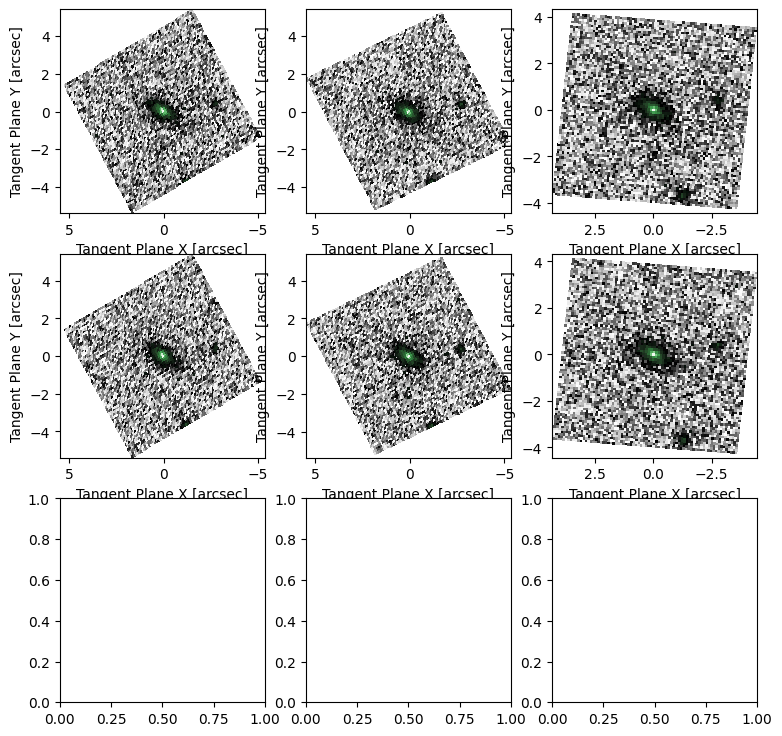

In [21]:
n = len(targets.image_list)
side = int(np.sqrt(n)) + 1
fig, ax = plt.subplots(side, side, figsize=(3 * side, 3 * side))

for i in range(n):
    ap.plots.target_image(fig, ax.ravel()[i], targets[i], window=windows[i], flipx=True)

plt.show()

The coordinate axes are in arcseconds, but in the local relative coordinate system for each image.  AstroPhot used the pixel scale to translate pixels -> arcsec.

Translate SN and host positions to projection plane positions for target.  By construction of our targets, this is in the same projection plane position.

In [22]:
transient_xy = targets[0].world_to_plane(transient_info["ra"], transient_info["dec"])
if len(transient_host["ra"]) > 1:
    host_xy = [targets[0].world_to_plane(r, d) for r, d in zip(transient_host["ra"], transient_host["dec"])]
else:
    host_xy = [targets[0].world_to_plane(transient_host["ra"], transient_host["dec"])]

### Plotting Convenience Function

In [23]:
# We divide up because "model_image" expects a single axis object if single image
# while it wants an array of axis objects if there are multiple images in the image list
# model_image will not accept a one-element array if there is no image_list
def plot_target_model(model, **kwargs):
    if hasattr(model.target, "image_list"):
        _plot_target_model_multiple(model, **kwargs)
    else:
        _plot_target_model_single(model, **kwargs)


def _plot_target_model_multiple(
    model,
    window=None,
    titles=None,
    base_figsize=(12, 4),
    figsize=None,
    plot_filename=None,
):
    n = len(model.target.image_list)
    if figsize is None:
        figsize = (base_figsize[0], n * base_figsize[1])
    fig, ax = plt.subplots(n, 3, figsize=figsize)
    # Would like to just call this, but window isn't parsed as a list
    # https://github.com/Autostronomy/AstroPhot/issues/142
    #    ap.plots.target_image(fig, ax[:, 0], model.target, window=window, flipx=True)
    for axt, mod, win in zip(ax[:, 0], model.target.image_list, window):
        ap.plots.target_image(fig, axt, mod, win, flipx=True)

    if titles is not None:
        for i, title in enumerate(titles):
            ax[i, 0].set_title(title)
    ap.plots.model_image(fig, ax[:, 1], model, window=window, flipx=True)
    ax[0, 1].set_title("Model")
    ap.plots.residual_image(fig, ax[:, 2], model, window=window, flipx=True)
    ax[0, 2].set_title("Residual")
    plt.show()
    if plot_filename is not None:
        plt.savefig(plot_filename)


def _plot_target_model_single(model, window=None, title=None, figsize=(16, 4)):
    fig, ax = plt.subplots(1, 3, figsize=figsize)
    ap.plots.target_image(fig, ax[0], model.target, window=window, flipx=True)
    ax[0].set_title(title)
    ap.plots.model_image(fig, ax[1], model, window=window, flipx=True)
    ax[1].set_title("Model")
    ap.plots.residual_image(fig, ax[2], model, window=window, flipx=True)
    ax[2].set_title("Residual")
    plt.show()

### Jointly fit model across images

In [24]:
live_sn = [
    (target.header.mjd > transient_info["mjd_start"])
    and (target.header.mjd < transient_info["mjd_end"])
    for target in targets
]

In [25]:
model_sky = []
model_static = []
model_sn = []

# The RomanDESC images are "raw" science images with sky.
FIT_SKY = {"RomanDESC": True}
FIT_HOST = True
FIT_SN = True
CORRECT_SIP = True

if FIT_SKY[DATASET]:
    for i, (target, window) in enumerate(zip(targets, windows)):
        model_sky.append(
            ap.models.AstroPhot_Model(
                name=f"sky model {i}",
                model_type="flat sky model",
                target=target,
                window=window,
            )
        )
    
# We might have multiple hosts in the scene.
# Potentially eventually multiple stars
if FIT_HOST:
    for i, hxy in enumerate(host_xy):        
        model_static_band = {}
        this_object_model = []
        
        for j, (b, target, window) in enumerate(zip(image_info["band"], targets, windows)):
            this_object_model.append(
                ap.models.AstroPhot_Model(
                    name=f"galaxy model {i,j}",
                    model_type="sersic galaxy model",
                    target=target,
                    psf_mode="full",
                    parameters={"center": hxy},
                    window=window,
                )
            )
            # I think this assignment copies reference that points to same underlying object
            # in 'model_host' and 'model_host_band'
            # The initialization step assumes that the reference model gets initialized first.
            # So we just mark use the first model in the list of each band.
            if b not in model_static_band.keys():
                model_static_band[b] = j
                
        # Define static by locking all parameters to the first in the band.
        for model in this_object_model:
            if model.name == this_object_model[model_static_band[b]].name:
                continue
            for parameter in ["q", "PA", "n", "Re", "Ie"]:
                model[parameter].value = this_object_model[model_static_band[b]][parameter]

        model_static.append(this_object_model)
        
if FIT_SN:
    for i, (ls, target, window) in enumerate(zip(live_sn, targets, windows)):
        if not ls:
            continue
        model_sn.append(
            ap.models.AstroPhot_Model(
                name=f"SN model {i}",
                model_type="point model",
                psf=target.psf,
                target=target,
                parameters={"center": transient_xy},
                window=window,
            )
        )

In [26]:
# AstroPhot doesn't handle SIP WCS yet.
# We'll roughly work around this by allowing a small shift in position
# for all (both) objects on the image.
CORRECT_SIP = True
if CORRECT_SIP:
    def calc_center(params):
        return params["nominal_center"].value + params["astrometric"].value

    if FIT_HOST and FIT_SN:
        host_center = [ap.param.Parameter_Node(
            name = "nominal_center",
            value = hxy    
        ) for hxy in host_xy]

        sn_center = ap.param.Parameter_Node(
            name = "nominal_center",
            value = transient_xy
        )
            
        live_sn_i = -1  # Accumulator to count live SN models
        for i, ls in enumerate(live_sn):
            # Require that we have the SN
            # because we need both Host and SN to do a joint astrometric offset fit
            if not ls:
                continue
            live_sn_i += 1
            # The x, y delta is the same for both the SN and host
            # but can be different for each image.
            P_astrometric = ap.param.Parameter_Node(
                name = "astrometric",
                value = [0, 0],
            )

            for j in range(len(host_center)):
                model_static[j][i]["center"].value = calc_center
                model_static[j][i]["center"].link(host_center[j], P_astrometric)
            
            model_sn[live_sn_i]["center"].value = calc_center
            model_sn[live_sn_i]["center"].link(sn_center, P_astrometric)
else:
    for b, model in zip(band, model_static):
        if model.name == model_static[model_static_band[b]].name:
            continue
        for parameter in ["center"]:
            model[parameter].value = model_static[model_static_band[b]][parameter]
    for b, model in zip(band, model_sn):
        if model.name == model_sn[model_static_band[b]].name:
            continue
        for parameter in ["center"]:
            model[parameter].value = model_host[model_static_band[b]][parameter]

Constrain host model to be the same per band

In [27]:
# Create a two-tier hierarchy of group models
# following recommendation from Connor Stone.

# Group model for each class: sky, host, sn
all_model_list = []
if len(model_sky) > 0:
    sky_group_model = ap.models.AstroPhot_Model(
        name="Sky",
        model_type="group model",
        models=[*model_sky],
        target=targets,
    )
    all_model_list.extend(sky_group_model)

for model_host in model_static:
    if len(model_host) > 0:
        host_group_model = ap.models.AstroPhot_Model(
            name="Host",
            model_type="group model",
            models=[*model_host],
            target=targets,
        )
        all_model_list.extend(host_group_model)

if len(model_sn) > 0:
    sn_group_model = ap.models.AstroPhot_Model(
        name="SN",
        model_type="group model",
        models=[*model_sn],
        target=targets,
    )
    all_model_list.extend(sn_group_model)

# Group model holds all the classes
model_host_sn = ap.models.AstroPhot_Model(
    name="Host+SN",
    model_type="group model",
    models=all_model_list,
    target=targets,
)

We have to initialize the model so that there is a value for `parameters["center"]`

In [28]:
model_host_sn.initialize()

[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


In [29]:
print(model_host_sn.parameters)

Host+SN:
center: [0.07075976599830547, 0.01882842264300555] +- 0.0 [arcsec], locked
F: 4.094943166076778 +- 0.006189402796171958 [log10(flux/arcsec^2)]
center: [0.0733657362939324, 0.023576086658521733] +- 0.0 [arcsec], locked
F: 4.029228672669422 +- 0.0064500749197894365 [log10(flux/arcsec^2)]
center: [-0.04799154146226048, -0.05710043633933992] +- 0.0 [arcsec], locked
F: 4.025834828084117 +- 0.006728308283529101 [log10(flux/arcsec^2)]
center: [0.07075976599830547, 0.01882842264300555] +- 0.0 [arcsec], locked
F: 4.094943166076778 +- 0.006189402796171958 [log10(flux/arcsec^2)]
center: [0.0733657362939324, 0.023576086658521733] +- 0.0 [arcsec], locked
F: 4.0256833919047725 +- 0.006727183847943193 [log10(flux/arcsec^2)]
center: [-0.04799154146226048, -0.05710043633933992] +- 0.0 [arcsec], locked
F: 4.025834828084117 +- 0.006728308283529101 [log10(flux/arcsec^2)]
nominal_center: [-0.006314909068559759, 0.002159999907780676] [none]
astrometric: [0.0, 0.0] [none]
q: 0.6499999999999999 +- 0.

In [30]:
result = ap.fit.LM(model_host_sn, verbose=True).fit()
print(result.message)

Chi^2/DoF: 7.2509243163404715, L: 1.0
Chi^2/DoF: 6.956345769985754, L: 1.6666666666666667
Chi^2/DoF: 6.860378116968981, L: 2.777777777777778
Chi^2/DoF: 6.299843671995855, L: 0.925925925925926
Chi^2/DoF: 5.43593304006683, L: 0.308641975308642
Chi^2/DoF: 5.2699745064976335, L: 0.5144032921810701
Chi^2/DoF: 5.226486260540396, L: 0.8573388203017834
Chi^2/DoF: 5.2124202043894865, L: 1.4288980338363058
Chi^2/DoF: 5.145198153484478, L: 0.47629934461210194
Chi^2/DoF: 5.126577690840317, L: 0.7938322410201698
Chi^2/DoF: 5.072566034412037, L: 0.26461074700672327
Chi^2/DoF: 5.062375362637374, L: 0.44101791167787213
Chi^2/DoF: 5.059501943204552, L: 0.7350298527964535
Chi^2/DoF: 5.047825370917708, L: 0.24500995093215117
Chi^2/DoF: 5.044326533894659, L: 0.40834991822025196
Chi^2/DoF: 5.043120037739613, L: 0.6805831970337533
Chi^2/DoF: 5.0426726579239745, L: 1.1343053283895888
Chi^2/DoF: 5.039616050069311, L: 0.3781017761298629
Chi^2/DoF: 5.0315975497206145, L: 0.12603392537662098
Chi^2/DoF: 5.0309364

In [31]:
result.update_uncertainty()

The uncertainties for the center positions and astrometric uncertainties aren't calculated correctly right now.

But the flux uncertainties are reasonable.

In [32]:
print(result.model.parameters)

Host+SN:
center: [0.07075976599830547, 0.01882842264300555] +- 0.0 [arcsec], locked
F: 4.085097298931471 +- 0.000533185782559073 [log10(flux/arcsec^2)]
center: [0.0733657362939324, 0.023576086658521733] +- 0.0 [arcsec], locked
F: 4.016820389951207 +- 0.0005728472535980053 [log10(flux/arcsec^2)]
center: [-0.04799154146226048, -0.05710043633933992] +- 0.0 [arcsec], locked
F: 4.017105680518526 +- 0.0005786968537556641 [log10(flux/arcsec^2)]
center: [0.07075976599830547, 0.01882842264300555] +- 0.0 [arcsec], locked
F: 4.085935100401427 +- 0.0005335213186549613 [log10(flux/arcsec^2)]
center: [0.0733657362939324, 0.023576086658521733] +- 0.0 [arcsec], locked
F: 4.016458999254586 +- 0.0005703476225286688 [log10(flux/arcsec^2)]
center: [-0.04799154146226048, -0.05710043633933992] +- 0.0 [arcsec], locked
F: 4.017540660784732 +- 0.0005784332427041671 [log10(flux/arcsec^2)]
nominal_center: [0.02232233056093594, 0.0011349600765659749] +- [109707.08047348405, 265882.4288125473] [none]
astrometric: 

In [33]:
model_filename = f"Transient_{transient_id}_AstroPhot_model.yaml"
result.model.save(model_filename)

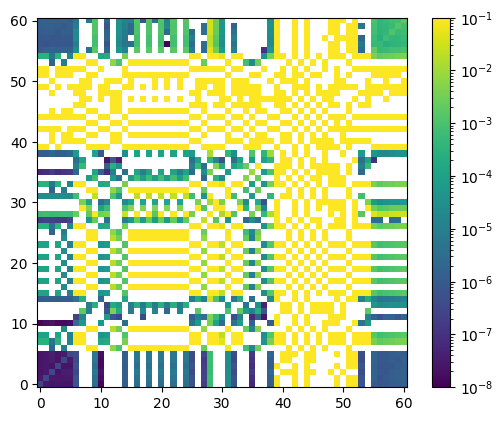

In [34]:
covar = result.covariance_matrix.detach().cpu().numpy()
plt.imshow(
    covar,
    origin="lower",
    vmin=1e-8, vmax=1e-1, norm="log",
)
plt.colorbar()

Let's focus on the SN flux uncertainties:

This is a little clunky because I don't have a better way of looking up the names of the parameters in the covariance matrix.

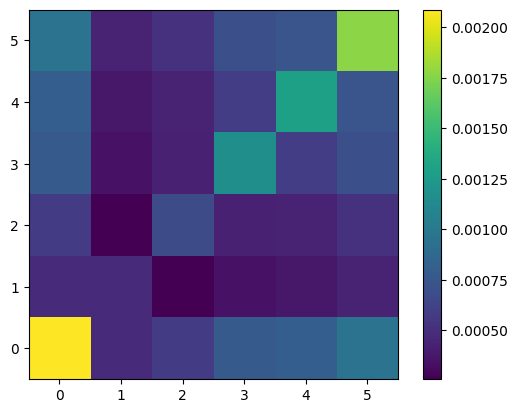

In [35]:
sn_flux_starts_at_parameter_idx = -len(targets.image_list)
covar = result.covariance_matrix.detach().cpu().numpy()
plt.imshow(
    covar[sn_flux_starts_at_parameter_idx:, sn_flux_starts_at_parameter_idx:],
    origin="lower",
#    vmin=1e-6, vmax=1, norm="log",
)
plt.colorbar()

In [36]:
sn_model_name_regex = re.compile("SN model [0-9]+")
sn_model_names = [k for k in model_host_sn.models.keys() if sn_model_name_regex.match(k)]

In [37]:
filenames = [model_host_sn.models[m].target.header.filename for m in sn_model_names]
bands = [model_host_sn.models[m].target.header.band for m in sn_model_names]
visits = [model_host_sn.models[m].target.header.visit for m in sn_model_names]
mjds = [model_host_sn.models[m].target.header.mjd for m in sn_model_names]
sim_zptmag = [model_host_sn.models[m].target.header.sim_zptmag for m in sn_model_names]

zp = np.array(
    [
        model_host_sn.models[m].target.zeropoint.detach().cpu().numpy()
        for m in sn_model_names
    ]
)
inst_mag = np.array(
    [
        -2.5 * model_host_sn.models[m].parameters["flux"].value.detach().cpu().numpy()
        for m in sn_model_names
    ]
)
mag_err = np.array(
    [
        2.5
        * model_host_sn.models[m].parameters["flux"].uncertainty.detach().cpu().numpy()
        for m in sn_model_names
    ]
)

In [38]:
lightcurve_obs = Table(
    {
        "filename": filenames,
        "band": bands,
        "visit": visits,
        "mjd": mjds,
        "zp": zp,
        "sim_zptmag": sim_zptmag,
        "inst_mag": inst_mag,
        "mag_err": mag_err,
    }
)

In [39]:
lightcurve_obs["mag"] = lightcurve_obs["inst_mag"] + lightcurve_obs["zp"] 
lightcurve_obs["inst_flux"] = 10 ** (-0.4 * lightcurve_obs["inst_mag"])
lightcurve_obs["inst_flux_err"] = (np.log(10) / 2.5) * (lightcurve_obs["inst_flux"] * mag_err)

lightcurve_obs["snr"] = lightcurve_obs["inst_flux"] / lightcurve_obs["inst_flux_err"]

In [40]:
zp_AB_to_nJy = 8.90 + 2.5 * 9

lightcurve_obs["flux"] = 10 ** (-0.4 * (lightcurve_obs["mag"] - zp_AB_to_nJy))
lightcurve_obs["flux_err"] = (lightcurve_obs["flux"] / lightcurve_obs["inst_flux"]) * lightcurve_obs[
    "inst_flux_err"
]

In [41]:
lightcurve_obs["mjd"].info.format = "<10.3f"
lightcurve_obs["zp"].info.format = ">7.4f"
lightcurve_obs["flux"].info.format=".3e"
lightcurve_obs["flux_err"].info.format=".3e"
lightcurve_obs["snr"].info.format="0.2f"
lightcurve_obs["mag"].info.format = ">7.4f"
lightcurve_obs["mag_err"].info.format = ">7.4f"

In [42]:
lightcurve_obs

filename,band,visit,mjd,zp,sim_zptmag,inst_mag,mag_err,mag,inst_flux,inst_flux_err,snr,flux,flux_err
str77,str4,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
data/RomanDESC/images/H158/1394/Roman_TDS_simple_model_H158_1394_9.fits.gz,H158,1394,62016.165,32.6030,17.63810856226013,-7.509670107027288,0.1142,25.0933,1008.9462785812759,106.14388245049979,9.51,3.332e+02,3.505e+01
data/RomanDESC/images/H158/8340/Roman_TDS_simple_model_H158_8340_17.fits.gz,H158,8340,62106.251,32.6030,17.63810856226013,-8.398116688957572,0.0550,24.2049,2286.8973728678457,115.86994737784278,19.74,7.552e+02,3.826e+01
data/RomanDESC/images/H158/14088/Roman_TDS_simple_model_H158_14088_8.fits.gz,H158,14088,62181.109,32.6030,17.63810856226013,-8.171355308276741,0.0649,24.4316,1855.846803939013,110.85522221723583,16.74,6.128e+02,3.661e+01
data/RomanDESC/images/H158/29499/Roman_TDS_simple_model_H158_29499_9.fits.gz,H158,29499,62381.165,32.6030,17.63810856226013,-7.848371012256337,0.0855,24.7546,1378.314753599009,108.55055283887903,12.70,4.551e+02,3.585e+01
data/RomanDESC/images/H158/36445/Roman_TDS_simple_model_H158_36445_17.fits.gz,H158,36445,62471.251,32.6030,17.63810856226013,-7.802784078269898,0.0901,24.8002,1321.641390812328,109.71399494602292,12.05,4.364e+02,3.623e+01
data/RomanDESC/images/H158/42193/Roman_TDS_simple_model_H158_42193_8.fits.gz,H158,42193,62546.109,32.6030,17.63810856226013,-7.621846765130869,0.1052,24.9812,1118.7645744998313,108.37691194313183,10.32,3.694e+02,3.579e+01


In [43]:
lightcurve_truth

visit,realized_flux,flux,mag
int64,float64,float64,float64
1394,74.0,70.2907753,10.456919
8340,1712.0,1703.64232,6.99571878
14088,1174.0,1188.39546,7.38676237
29499,368.0,337.472264,8.75356962
36445,222.0,199.624893,9.32362809


In [44]:
from astropy.table import join

lightcurve = join(
    lightcurve_truth,
    lightcurve_obs[
        [
            "filename",
            "visit",
            "band",
            "mjd",
            "zp",
            "sim_zptmag",
            "inst_mag",
            "mag_err",
            "mag",
            "inst_flux",
            "inst_flux_err",
            "snr",
            "flux",
            "flux_err",
        ]
    ],
    keys_left=["visit"],
    keys_right=["visit"],
    join_type="right",
    table_names=("truth", "obs"),
)
# Need to add the ZPTMAG stored in the FITS image header to the 'mag' value in the truth file
# to get the calibrated AB-system magnitude
lightcurve["mag_truth"] += lightcurve["sim_zptmag"]

In [45]:
lightcurve

visit_truth,realized_flux,flux_truth,mag_truth,filename,visit_obs,band,mjd,zp,sim_zptmag,inst_mag,mag_err,mag_obs,inst_flux,inst_flux_err,snr,flux_obs,flux_err
int64,float64,float64,float64,str77,int64,str4,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1394,74.0,70.2907753,28.095027562260128,data/RomanDESC/images/H158/1394/Roman_TDS_simple_model_H158_1394_9.fits.gz,1394,H158,62016.165,32.6030,17.63810856226013,-7.509670107027288,0.1142,25.0933,1008.9462785812759,106.14388245049979,9.51,3.332e+02,3.505e+01
8340,1712.0,1703.64232,24.63382734226013,data/RomanDESC/images/H158/8340/Roman_TDS_simple_model_H158_8340_17.fits.gz,8340,H158,62106.251,32.6030,17.63810856226013,-8.398116688957572,0.0550,24.2049,2286.8973728678457,115.86994737784278,19.74,7.552e+02,3.826e+01
14088,1174.0,1188.39546,25.02487093226013,data/RomanDESC/images/H158/14088/Roman_TDS_simple_model_H158_14088_8.fits.gz,14088,H158,62181.109,32.6030,17.63810856226013,-8.171355308276741,0.0649,24.4316,1855.846803939013,110.85522221723583,16.74,6.128e+02,3.661e+01
29499,368.0,337.472264,26.39167818226013,data/RomanDESC/images/H158/29499/Roman_TDS_simple_model_H158_29499_9.fits.gz,29499,H158,62381.165,32.6030,17.63810856226013,-7.848371012256337,0.0855,24.7546,1378.314753599009,108.55055283887903,12.70,4.551e+02,3.585e+01
36445,222.0,199.624893,26.96173665226013,data/RomanDESC/images/H158/36445/Roman_TDS_simple_model_H158_36445_17.fits.gz,36445,H158,62471.251,32.6030,17.63810856226013,-7.802784078269898,0.0901,24.8002,1321.641390812328,109.71399494602292,12.05,4.364e+02,3.623e+01
--,--,--,--,data/RomanDESC/images/H158/42193/Roman_TDS_simple_model_H158_42193_8.fits.gz,42193,H158,62546.109,32.6030,17.63810856226013,-7.621846765130869,0.1052,24.9812,1118.7645744998313,108.37691194313183,10.32,3.694e+02,3.579e+01


In [46]:
color_for_band = {
    "u": "purple",
    "g": "blue",
    "r": "green",
    "i": "red",
    "z": "black",
    "y": "yellow",
    "Y": "blue",
    "J": "green",
    "H": "red",
    "F": "black",
    "Y106": "blue",
}
color_for_band["H158"] = color_for_band["H"]

(61989.6678, 62572.606199999995)

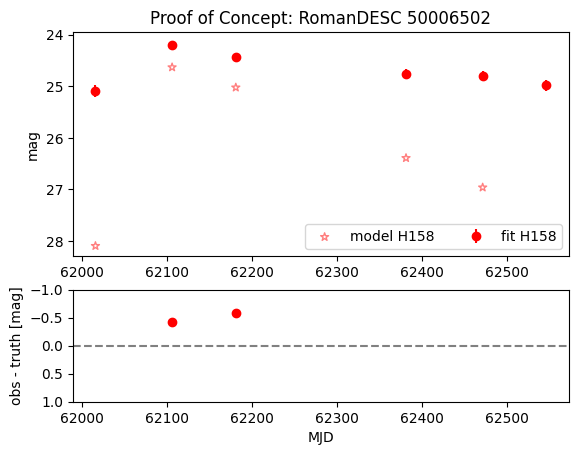

In [47]:
_, axes = plt.subplots(2, 1, height_ratios=[2, 1])

ax = axes[0]

snr_threshold = 1
for b in np.unique(lightcurve_obs["band"]):
    (idx,) = np.where(
        (lightcurve_obs["band"] == b) & (lightcurve_obs["snr"] > snr_threshold)
    )
    ax.errorbar(
        lightcurve_obs[idx]["mjd"],
        lightcurve_obs[idx]["mag"],
        lightcurve_obs[idx]["mag_err"],
        marker="o",
        markerfacecolor=color_for_band[b],
        markeredgecolor=color_for_band[b],
        ecolor=color_for_band[b],
        linestyle="none",
        label=f"fit {b}",
    )
ax.set_ylabel("mag")
# ax.set_xlabel("MJD")
ax.set_title(f"Proof of Concept: {DATASET} {transient_id}")
plt.ylim(23.5, 19)


if lightcurve_truth is not None:
    for b in np.unique(lightcurve["band"]):
        (idx,) = np.where(lightcurve["band"] == b)
        ax.scatter(
            lightcurve[idx]["mjd"],
            lightcurve[idx]["mag_truth"],
            edgecolor=color_for_band[b],
            facecolor="none",
            alpha=0.5,
            marker="*",
            label=f"model {b}",
        )

ax.set_ylim(ax.get_ylim()[::-1]);

ax.legend(ncols=2)

###
ax = axes[1]

for b in np.unique(lightcurve["band"]):
    (idx,) = np.where(
        (lightcurve["band"] == b)
    )
    ax.errorbar(
        lightcurve[idx]["mjd"],
        lightcurve[idx]["mag_obs"] - lightcurve[idx]["mag_truth"],
        lightcurve[idx]["mag_err"],
        marker="o",
        markerfacecolor=color_for_band[b],
        markeredgecolor=color_for_band[b],
        ecolor=color_for_band[b],
        linestyle="none",
        label=f"{b}",
    )
ax.set_ylabel("obs - truth [mag]")
ax.set_xlabel("MJD")
# plt.ylim(23.5, 17)
ax.axhline(0, color="gray", ls="--")
ax.set_ylim(1, -1)
ax.set_xlim(axes[0].get_xlim())

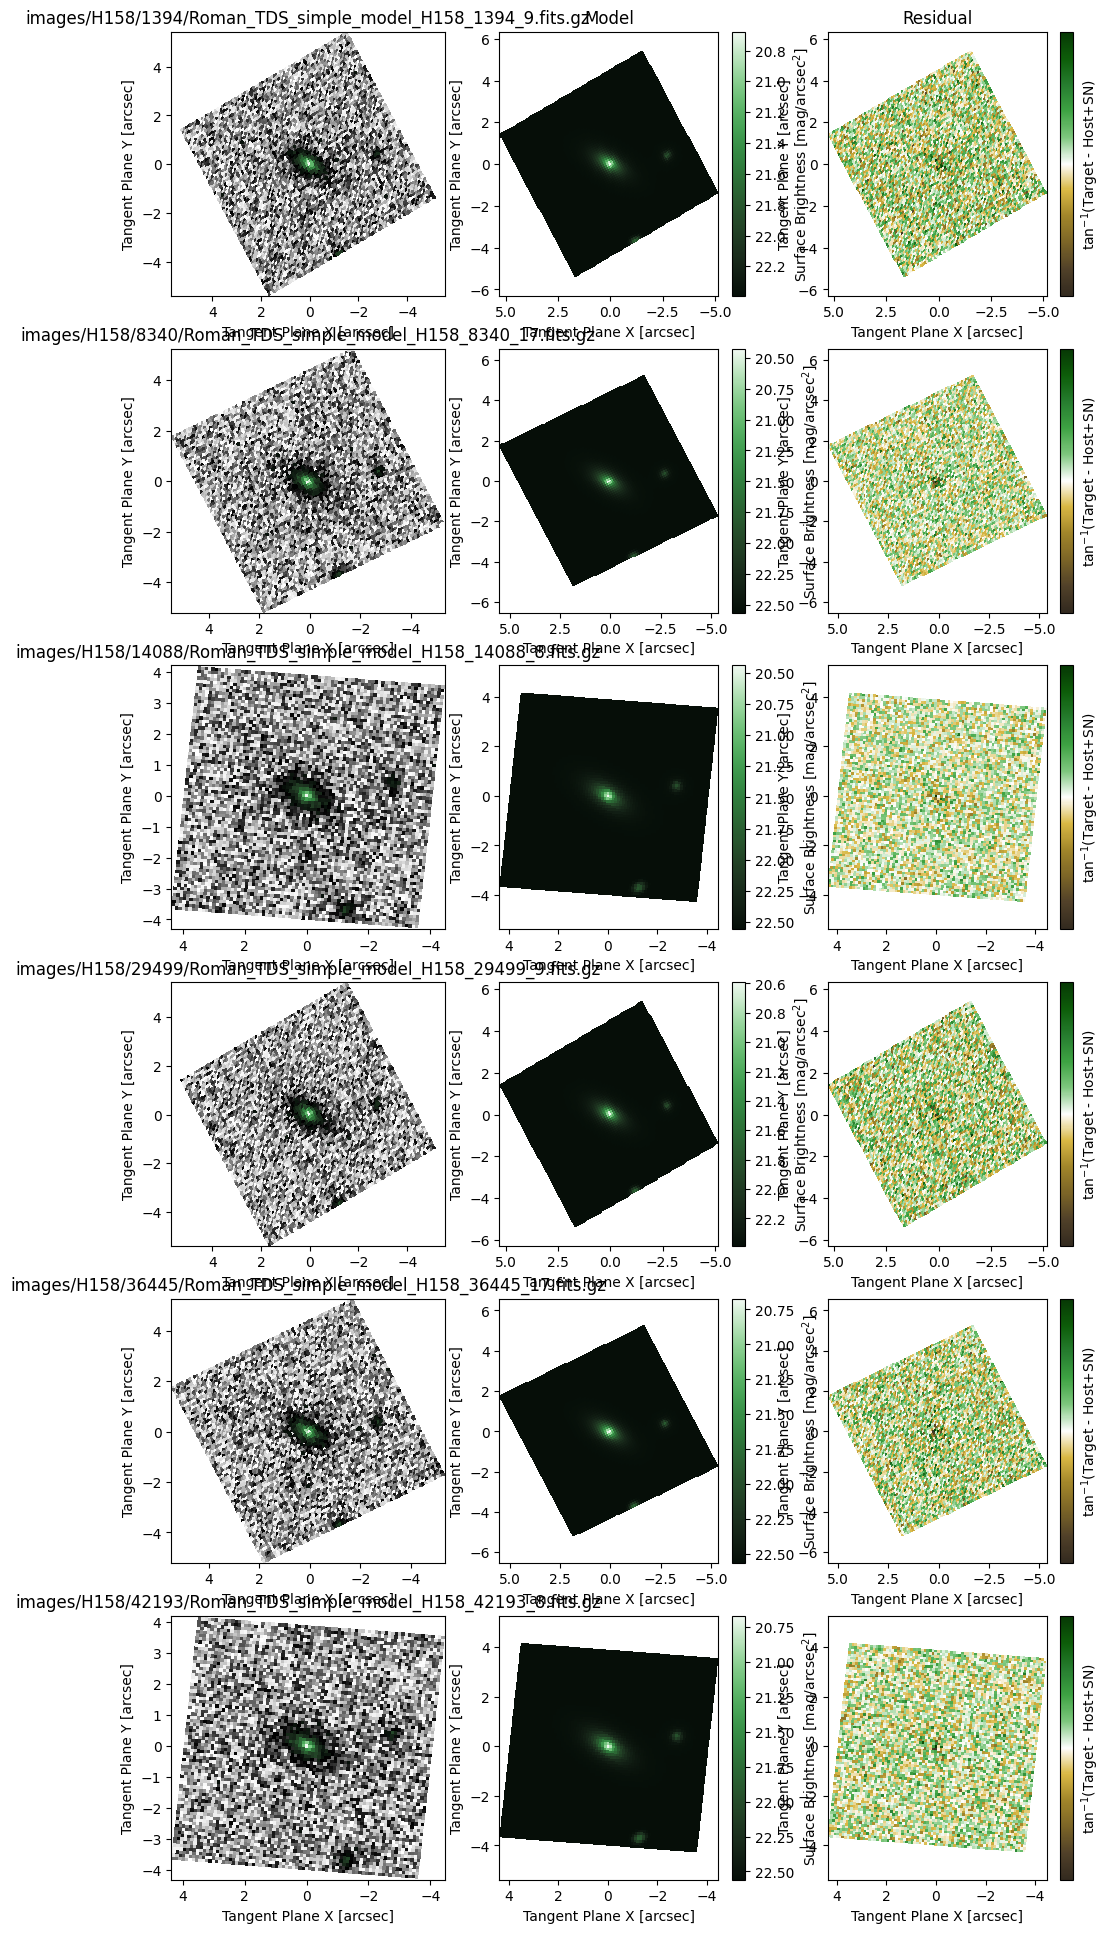

<Figure size 640x480 with 0 Axes>

In [48]:
plot_target_model(
    model_host_sn,
    window=windows,
    titles=image_file_basenames,
    plot_filename=f"sn_{DATASET}_{transient_id}_model.png",
)